In [1]:
from ipywidgets import FloatProgress, Button, HBox
from IPython.display import display
from time import sleep
    
class Controller:
    progress = FloatProgress(value=0.0, min=0.0, max=1.0, description="%")
    button = Button()
    panic = False
    thread = None
    
    def __init__(self, simulation, setup, viewer):
        self.target = simulation.run
        self.setup = setup
        self.viewer = viewer
        self._setup_play()
        
    def __enter__(self):
        self.panic = False

    def __exit__(self, *_):
        self.panic = False
        self._setup_play()
                
    def reinit(self, _=None):
        self._setup_play()
        self.progress.value = 0
            
    def box(self):
        return HBox([self.progress, self.button])

    def set_percent(self, value):
        self.progress.value = value
        
    def _setup_play(self):
        self.button.on_click(self._handle_stop, remove=True)
        self.button.on_click(self._handle_play)
        self.button.icon = 'play'

    def _setup_stop(self):
        self.button.on_click(self._handle_play, remove=True)
        self.button.on_click(self._handle_stop)
        self.button.icon = 'stop'

    def _handle_stop(self, _):
        self.panic = True
        while self.panic: sleep(0.1)
        self._setup_play()

    def _handle_play(self, _):
        from threading import Thread
        self.thread = Thread(target=self.target, args=(self,))
        self.thread.start()
        self._setup_stop()
        #self.viewer.reinit()

In [2]:
class Storage:
    data = {}
    
    def reinit(self, _=None):
        self.data.clear()
    
    def save(self, state, step):
        self.data[step] = state.copy()

In [3]:
from ipywidgets import IntSlider

class Setup:
    nt = IntSlider(value=100,  max=100, description="nt")
    nx = IntSlider(value=1000, max=1000, description="nx")
    nz = IntSlider(value=1000, max=1000, description="nz")
    
    def box(self):
        return VBox([self.nt, self.nx, self.nz])

In [4]:
import numpy as np

class Simulation:
    def __init__(self, setup, storage):
        self.setup = setup
        self.storage = storage
        
    def run(self, controller):
        self.storage.reinit()
        with(controller):
            self.state = np.zeros((self.setup.nx.value, self.setup.nz.value))
            self.storage.save(self.state, step=0)
            for step in range(self.setup.nt.value):
                if controller.panic: break 
                self.state += np.random.rand(self.setup.nx.value, self.setup.nz.value)
                self.storage.save(self.state, step=step)
                controller.set_percent(float(step+1)/self.setup.nt.value)

In [5]:
from ipywidgets import VBox, Box, Play, Output, IntSlider, jslink
from matplotlib.pyplot import imshow, show, draw, colorbar
from IPython.display import clear_output

class Viever:
    play = Play()
    slider = IntSlider()
    plot = Output()

    def __init__(self, storage, setup):
        self.storage = storage
        self.setup = setup
        self.reinit()
    
    def reinit(self, _= None):
        self.slider.max = setup.nt.value
        self.play.max = setup.nt.value
        self.play.value = 0
        self.slider.value = 0
        with self.plot:
            clear_output()
            self.im = imshow(np.zeros((self.setup.nx.value, self.setup.nz.value)), cmap='GnBu')
            self.im.set_clim(vmin=0, vmax=10)
            colorbar()
            show()
            
    def replot(self, bunch):
        step = bunch.new
        with self.plot:
            if step in self.storage.data:
                self.im.set_data(self.storage.data[step])
                clear_output(wait=True)
                display(self.im.figure)
            else:
                clear_output()
                print("not yet calculated @ step=" + str(step))
    
    def box(self):
        jslink((self.play, 'value'), (self.slider, 'value'))
        self.play.observe(self.replot, 'value')
        return VBox([Box([self.play, self.slider]), self.plot])

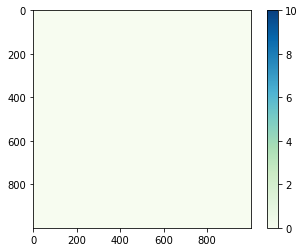

In [6]:
from IPython.display import display
from ipywidgets import Tab

setup = Setup()
storage = Storage()
simulation = Simulation(setup, storage)
viewer = Viever(storage, setup)
controller = Controller(simulation, setup, viewer)

tabs = Tab([
    setup.box(),
    VBox([controller.box(), viewer.box()])
])
tabs.set_title(0, "Setup")
tabs.set_title(1, "Simulation")
tabs.observe(viewer.reinit, 'selected_index')
tabs.observe(controller.reinit, 'selected_index')
tabs.observe(storage.reinit, 'selected_index')
display(tabs)
